# Load Libraries

In [2]:
import numpy as np
import pandas as pd
import six
from random import randint
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import tensorflow as tf
import keras
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.losses import binary_crossentropy

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

from keras.preprocessing.image import load_img
from keras import optimizers
from keras.legacy import interfaces

from keras.utils.generic_utils import get_custom_objects

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
##import tensorflow_federated as tff
#from tensorflow.keras.optimizers import SGD
#from tensorflow.keras import layers
#from tensorflow import keras
from skimage.transform import resize
from keras.preprocessing.image import load_img
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import flwr as fl

In [3]:
tf.__version__

'1.7.0-rc1'

# Params and helpers

In [4]:
img_size_ori = 101
img_size_target = 128

def upsample2(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', order=0, preserve_range=True).astype(np.uint8)

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [3]:
#!unzip /kaggle/input/tgs-salt-identification-challenge/train.zip
#!unzip /kaggle/input/tgs-salt-identification-challenge/test.zip

In [5]:
#from tqdm.notebook import tqdm
def get_img_dataset(image_dir,mask_dir, max_=255.0):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

    train_df1 = pd.DataFrame({
        'image_paths': image_files,
        'mask_paths': mask_files
    })
    train_df1["images"] = [
        np.array(load_img(img_path, grayscale=True)) / max_ for img_path in tqdm_notebook(train_df1["image_paths"])
    ]
    train_df1["masks"] = [
        (np.array(load_img(mask_path, grayscale=True)) > 0).astype(np.float32) for mask_path in tqdm_notebook(train_df1["mask_paths"])
    ]

    return train_df1


In [6]:
image_dir = "/kaggle/input/tgs-train-test/train-tgs/images"
mask_dir = "/kaggle/input/tgs-train-test/train-tgs/masks"
train_df1 = get_img_dataset(image_dir,mask_dir)

image_dir = "/kaggle/input/seam11/images"
mask_dir = "/kaggle/input/seam11/masks"
train_df2 = get_img_dataset(image_dir,mask_dir)

image_dir = "/kaggle/input/f3-train/images"
mask_dir = "/kaggle/input/f3-train/masks"
train_df3 = get_img_dataset(image_dir,mask_dir)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [7]:
# Define bin edges and labels
bin_edges = np.linspace(0, 1, 11)  # Divide the range [0, 1] into 10 equal bins
bin_labels = list(range(10))  # Labels for the bins (0 to 9)

# Calculate the coverage
train_df1["coverage"] = train_df1.masks.map(np.sum) / pow(img_size_ori, 2)

# Use pd.cut to assign coverage_class
train_df1["coverage_class"] = pd.cut(
    train_df1["coverage"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

In [8]:
# Define bin edges and labels
bin_edges = np.linspace(0, 1, 11)  # Divide the range [0, 1] into 10 equal bins
bin_labels = list(range(10))  # Labels for the bins (0 to 9)

# Calculate the coverage
train_df2["coverage"] = train_df2.masks.map(np.sum) / pow(img_size_ori, 2)

# Use pd.cut to assign coverage_class
train_df2["coverage_class"] = pd.cut(
    train_df2["coverage"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)


In [9]:
# Define bin edges and labels
bin_edges = np.linspace(0, 1, 11)  # Divide the range [0, 1] into 10 equal bins
bin_labels = list(range(10))  # Labels for the bins (0 to 9)

# Calculate the coverage
train_df3["coverage"] = train_df3.masks.map(np.sum) / pow(img_size_ori, 2)

# Use pd.cut to assign coverage_class
train_df3["coverage_class"] = pd.cut(
    train_df3["coverage"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)


In [10]:
train_df11, valid_df1 = train_test_split(train_df1, test_size=0.20, stratify=train_df1.coverage_class, random_state=31)
train_df22, valid_df2 = train_test_split(train_df2, test_size=0.20, stratify=train_df2.coverage_class, random_state=31)
train_df33, valid_df3 = train_test_split(train_df3, test_size=0.20, stratify=train_df3.coverage_class, random_state=31)

In [11]:
x_train1 = np.array(train_df11.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_train1 = np.array(train_df11.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_train1 = np.repeat(x_train1, 3, axis=-1)
#y_train1 = np.repeat(y_train1, 3, axis=-1)

In [53]:
x_valid1 = np.array(valid_df1.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_valid1 = np.array(valid_df1.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_valid1 = np.repeat(y_valid1, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

In [12]:
x_train2 = np.array(train_df22.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_train2 = np.array(train_df22.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_train2 = np.repeat(x_train2, 3, axis=-1)
#y_train2 = np.repeat(y_train2, 3, axis=-1)

In [55]:
x_valid2 = np.array(valid_df2.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_valid2 = np.array(valid_df2.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_valid2 = np.repeat(y_valid2, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

In [13]:
x_train3 = np.array(train_df33.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_train3 = np.array(train_df33.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_train3 = np.repeat(x_train3, 3, axis=-1)
#y_train3 = np.repeat(y_train3, 3, axis=-1)

In [57]:
x_valid3 = np.array(valid_df3.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_valid3 = np.array(valid_df3.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_valid3 = np.repeat(y_valid3, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

In [14]:
valid_df = pd.concat([valid_df1,valid_df2,valid_df3])
x_valid = np.array(valid_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_valid = np.array(valid_df.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_valid = np.repeat(x_valid, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

In [13]:
train_df = pd.concat([train_df11,train_df22,train_df33])
x_train = np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_train = np.array(train_df.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_train = np.repeat(x_train, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

In [14]:
def calculate_foreground_percentage(masks_array, img_size_ori):
    """
    Calculates the total percentage of foreground and background pixels across all masks.

    Args:
        masks_array: A NumPy array of binary masks.
        img_size_ori: The original size of the images.

    Returns:
        A tuple containing (total_foreground_percentage, total_background_percentage).
    """
    total_pixels_all_images = len(masks_array) * (img_size_ori * img_size_ori)
    total_foreground_pixels = np.sum(masks_array)
    total_background_pixels = total_pixels_all_images - total_foreground_pixels

    total_foreground_percentage = (total_foreground_pixels / total_pixels_all_images) * 100
    total_background_percentage = (total_background_pixels / total_pixels_all_images) * 100

    return total_foreground_pixels / total_pixels_all_images

In [23]:
client_data = ((x_train1, y_train1), (x_train2, y_train2), (x_train3, y_train3))

In [16]:
client_fg_percent = [calculate_foreground_percentage(y_train1, 128), calculate_foreground_percentage(y_train2, 128), calculate_foreground_percentage(y_train3, 128)]

In [17]:
total_foreground_percentage = sum(client_fg_percent)
weights = [fp / total_foreground_percentage for fp in client_fg_percent]

In [ ]:
# Combining fg weight and data size
# Calculate foreground percentages
client_fg_percent = [
    calculate_foreground_percentage(y_train1, 128),
    calculate_foreground_percentage(y_train2, 128),
    calculate_foreground_percentage(y_train3, 128)
]

# Get data sizes for each client
client_data_sizes = [
    len(y_train1),
    len(y_train2),
    len(y_train3)
]

# Normalize both foreground % and data size
total_fg = sum(client_fg_percent)
total_data = sum(client_data_sizes)

norm_fg = [fp / total_fg for fp in client_fg_percent]
norm_data = [ds / total_data for ds in client_data_sizes]

# Final weights: geometric mean (or you can use a weighted sum instead)
weights = [ (fg * ds) for fg, ds in zip(norm_fg, norm_data) ]
total_weight = sum(weights)
weights = [w / total_weight for w in weights]  # Normalize to sum to 1


In [33]:
image_dir = "/kaggle/input/tgs-train-test/test-tgs/images"
mask_dir = "/kaggle/input/tgs-train-test/test-tgs/masks"
test_df1 = get_img_dataset(image_dir,mask_dir)

A Jupyter Widget

A Jupyter Widget

In [34]:

x_test1 = np.array(test_df1.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_test1 = np.array(test_df1.masks.map(upsample2).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_test1 = np.repeat(x_test1, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [7]:
import os

# Directory paths
image_dir = "/kaggle/input/seam11/images"
mask_dir = "/kaggle/input/seam11/masks"

#image_dir = "/kaggle/input/test-f3/test_f3/images"
#mask_dir = "/kaggle/input/test-f3/test_f3/masks"

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])


#image_dir = "/kaggle/input/f3-train/images"
#mask_dir = "/kaggle/input/f3-train/masks"

#test_img = '//kaggle/input/seam-test2/images'
#test_mask = '/kaggle/input/seam-test2/masks'

#image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
#mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

# Get list of image file names (assuming .png files)
##image_files = sorted([os.path.join(test_img, f) for f in os.listdir(test_img) if f.endswith('.png')])
#mask_files = sorted([os.path.join(test_mask, f) for f in os.listdir(test_mask) if f.endswith('.png')])


In [8]:
train_df2 = pd.DataFrame({
    'image_paths': image_files,
    'mask_paths': mask_files
})

In [12]:
train_df1["images"] = [
    np.array(load_img(img_path, grayscale=True)) / 255 for img_path in tqdm_notebook(train_df1["image_paths"])
]

train_df1["masks"] = [
    np.array(load_img(mask_path, grayscale=True)) / 255 for mask_path in tqdm_notebook(train_df1["mask_paths"])
]


KeyError: 'image_paths'

In [6]:
test_images = np.array(test_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
test_masks = np.array(test_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

In [10]:
train_df2["images"] = [
    np.array(load_img(img_path, grayscale=True)) / 255 for img_path in tqdm_notebook(train_df2["image_paths"])
]


A Jupyter Widget

In [ ]:
train_df2 = pd.DataFrame({
    'image_paths': image_files,
    'mask_paths': mask_files
})

In [9]:
train_df2["images"] = [
    np.array(load_img(img_path, grayscale=True)) / 255 for img_path in tqdm_notebook(train_df2["image_paths"])
]


A Jupyter Widget

In [11]:
train_df2["masks"] = [
    np.array(load_img(mask_path, grayscale=True)) / 255 for mask_path in tqdm_notebook(train_df2["mask_paths"])
]


A Jupyter Widget

In [29]:

image_dir = "/kaggle/input/f3-train/images"
mask_dir = "/kaggle/input/f3-train/masks"
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])


In [30]:
train_df3 = pd.DataFrame({
    'image_paths': image_files,
    'mask_paths': mask_files
})

In [31]:
train_df3["images"] = [
    np.array(load_img(img_path, grayscale=True)) / 255 for img_path in tqdm_notebook(train_df3["image_paths"])
]


train_df3["masks"] = [
    np.array(load_img(mask_path, grayscale=True)) / 255 for mask_path in tqdm_notebook(train_df3["mask_paths"])
]


A Jupyter Widget

A Jupyter Widget

In [13]:
#!unzip /kaggle/input/tgs-salt-identification-challenge/train.zip

In [14]:
#test_df["images"] = [np.array(load_img("/kaggle/working/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(test_df.index)]
#!unzip /kaggle/input/tgs-salt-identification-challenge/test.zip

In [13]:
train_df1["images"] = [np.array(load_img("/kaggle/working/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df1.index)]

A Jupyter Widget

In [14]:
train_df1["masks"] = [np.array(load_img("/kaggle/working/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df1.index)]

A Jupyter Widget

In [ ]:
#test_df["images"] = [np.array(load_img("/kaggle/working/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(test_df.index)]

In [ ]:
#test_images = np.array(test_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [15]:
train_df1["coverage"] = train_df1.masks.map(np.sum) / pow(img_size_ori, 2)

In [16]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
train_df1["coverage_class"] = train_df1.coverage.map(cov_to_class)


In [17]:
train_df11, test_df1 = train_test_split(train_df1, test_size=0.2, stratify=train_df1.coverage_class, random_state=31)

In [18]:
test_df1.shape

(800, 5)

In [19]:
train_df = pd.concat([train_df11[['images', 'masks']],train_df2[['images', 'masks']]],axis=0)

In [20]:
train_df.tail()

,images,masks
3191,"[[0.36470588235294116, 0.3764705882352941, 0.3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3192,"[[0.3568627450980392, 0.3607843137254902, 0.35...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3193,"[[0.34509803921568627, 0.34509803921568627, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3194,"[[0.3411764705882353, 0.3215686274509804, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3195,"[[0.34509803921568627, 0.34509803921568627, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [21]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [22]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


In [ ]:
#train_df[['coverage','coverage_class']].to_csv('coverage.csv')

# Show some example images

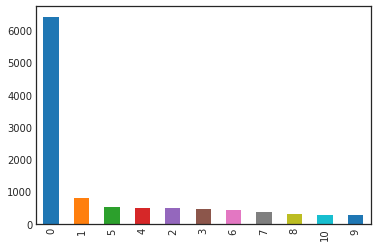

In [42]:
train_df.coverage_class.value_counts().plot.bar()

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [23]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=31)

In [25]:
x_test = np.array(test_df1.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_test = np.array(test_df1.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:

#x_test3 = np.array(test_df3.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#y_test3 = np.array(test_df3.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:

#test_images = np.array(test_images.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#y_test3 = np.array(test_df3.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
#test_images=test_images.reshape(18000, 128, 128, 1)

In [ ]:
#test_images.shape

In [15]:
!pip install segmentation-models

    100% |████████████████████████████████| 51kB 6.7MB/s eta 0:00:01
You are using pip version 9.0.1, however version 25.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [26]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(10232, 128, 128, 1)
(1280, 128, 128, 1)


In [27]:
#Transforming to 3 channels to match the model dimensions
x_train = np.repeat(x_train, 3, axis=-1)
x_valid = np.repeat(x_valid, 3, axis=-1)

In [28]:
x_train.shape

(10232, 128, 128, 3)

In [28]:
#Transforming to 3 channels to match the model dimensions
x_test = np.repeat(x_test, 3, axis=-1)

In [8]:
test_images  = np.repeat(test_images, 3, axis=-1)

In [ ]:
#x_test.shape

# Metrics

In [16]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [15]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [23]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./u_tgs_seam.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [18]:

def l2_norm(grad):
    norm = K.sqrt(K.sum(K.square(grad))) + K.epsilon()
    return norm

class OptimizerWrapper(optimizers.Optimizer):

    def __init__(self, optimizer):     
        
        self.optimizer = optimizers.get(optimizer)

        # patch the `get_gradients` call
        self._optimizer_get_gradients = self.optimizer.get_gradients

    def get_gradients(self, loss, params):      
        grads = self._optimizer_get_gradients(loss, params)
        return grads

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        # monkey patch `get_gradients`
        self.optimizer.get_gradients = self.get_gradients

        # get the updates
        self.optimizer.get_updates(loss, params)

        # undo monkey patch
        self.optimizer.get_gradients = self._optimizer_get_gradients

        return self.updates

    def set_weights(self, weights):       
        self.optimizer.set_weights(weights)

    def get_weights(self):        
        return self.optimizer.get_weights()

    def get_config(self):       
        # properties of NormalizedOptimizer
        config = {'optimizer_name': self.optimizer.__class__.__name__.lower()}

        # optimizer config
        optimizer_config = {'optimizer_config': self.optimizer.get_config()}
        return dict(list(optimizer_config.items()) + list(config.items()))

    @property
    def weights(self):
        return self.optimizer.weights

    @property
    def updates(self):
        return self.optimizer.updates

    @classmethod
    def from_config(cls, config):
        raise NotImplementedError

    @classmethod
    def set_normalization_function(cls, name, func):
        global _NORMS
        _NORMS[name] = func

    @classmethod
    def get_normalization_functions(cls):        
        global _NORMS
        return sorted(list(_NORMS.keys()))


class NormalizedOptimizer(OptimizerWrapper):

    def __init__(self, optimizer, normalization='l2'):       
        super(NormalizedOptimizer, self).__init__(optimizer)

        if normalization not in _NORMS:
            raise ValueError('`normalization` must be one of %s.\n' 
                             'Provided was "%s".' % (str(sorted(list(_NORMS.keys()))), normalization))

        self.normalization = normalization
        self.normalization_fn = _NORMS[normalization]
        self.lr = K.variable(1e-3, name='lr')

    def get_gradients(self, loss, params):       
        grads = super(NormalizedOptimizer, self).get_gradients(loss, params)
        grads = [grad / self.normalization_fn(grad) for grad in grads]
        return grads

    def get_config(self):        
        # properties of NormalizedOptimizer
        config = {'normalization': self.normalization}

        # optimizer config
        base_config = super(NormalizedOptimizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):       
        optimizer_config = {'class_name': config['optimizer_name'],
                            'config': config['optimizer_config']}

        optimizer = optimizers.get(optimizer_config)
        normalization = config['normalization']

        return cls(optimizer, normalization=normalization)


_NORMS = {
    'l2': l2_norm,
}

# register this optimizer to the global custom objects when it is imported
get_custom_objects().update({'NormalizedOptimizer': NormalizedOptimizer})

In [26]:

class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [19]:
from segmentation_models import Unet, Linknet, FPN, PSPNet
from segmentation_models import get_preprocessing, backbones
from tensorflow import layers

BACKBONE = 'efficientnetb7'  # or your specific variant like efficientnetb0
#model2 = Unet(BACKBONE, input_shape=(128, 128, 3), encoder_weights='imagenet')  
#model1 = Unet(BACKBONE, input_shape=(128, 128, 3), encoder_weights='imagenet')  

#c = optimizers.adam(lr = 0.001)
#model1.compile(loss=bce_dice_loss, optimizer=c, metrics=[my_iou_metric])


Segmentation Models: using `keras` framework.


In [20]:
def create_model():
    BACKBONE = 'efficientnetb7'  # or your specific variant like efficientnetb0
    model1 = Unet(BACKBONE, input_shape=(128, 128, 3), encoder_weights='imagenet')  
    model1.load_weights('/kaggle/input/saltnet_fedavg_v1/keras/default/1/fed_avg_b7_v1_weights.h5')
    #sgd = SGD(0.001, momentum=0.9, nesterov=True)
    #sgd = NormalizedOptimizer(sgd, normalization='l2')
    c = optimizers.adam(lr = 0.001)
    model1.compile(loss=bce_dice_loss, optimizer=c, metrics=[my_iou_metric])
    return model1

# Global Model


In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=15, verbose=1)
model_checkpoint = ModelCheckpoint('centralized_saltnetv1.h5',monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True,save_weights_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 32
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,early_stopping], 
                    verbose=2)

In [21]:
global_model = create_model()
#global_temp_model = create_model()
local_model = create_model()
#global_model.set_weights(model1.get_weights())

258441216/258434480 [==============================] - ETA:  - 1s 0us/step


In [ ]:
import tensorflow as tf
import numpy as np

# Assuming you have:
# - global_model (your Keras model)
# - local_model (a copy of global_model used for local training)
# - client_data (a list of tuples, each tuple containing X and y for a client)
# - x_valid, y_valid (validation data)

# Number of rounds for federated learning
num_rounds = 110
num_clients = 3
globaliou_=[]
localiou_=[]
temp_global_model_weights = []

best_global_iou = 0.0  # Initialize best global IoU

for round_num in range(num_rounds):
    print(f"Round {round_num + 1}/{num_rounds}")

    local_weights = []

    # Train on each client
    for client_id in range(num_clients):
        #print(f"Training on client {client_id + 1}")

        # Create local model and set global weights
        local_model.set_weights(global_model.get_weights())

        # Get client data
        X, y = client_data[client_id]
        #print(f"Training Starts on client {client_id + 1}")
        with tf.device('/GPU:0'):
            # Train local model
        
            local_model.fit(X, y, epochs=1, batch_size=32, verbose=0)
        loss, iou = local_model.evaluate(x_valid, y_valid, verbose=0)
        localiou_.append(iou)
        #print(f"Local model iou after round {round_num + 1}: {iou:.4f}")
        # Collect local model weights
        local_weights.append(local_model.get_weights())

    # Federated averaging: Aggregate local weights
    #averaged_weights = [np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
    #                    for i in range(len(local_weights[0]))]
    num_samples = [len(client_data[i][0]) for i in range(num_clients)]
    total_samples = sum(num_samples)
    averaged_weights = [ np.sum([local_weights[j][i] * (num_samples[j] / total_samples) for j in range(num_clients)], axis=0)
    for i in range(len(local_weights[0]))]
    #averaged_weights = [
    #np.sum([local_weights[j][i] * weights[j] for j in range(num_clients)], axis=0)
    #for i in range(len(local_weights[0]))]
    # Evaluate the global model with the averaged weights
    
    global_model.set_weights(averaged_weights) #update the real model.
    loss, iou = global_model.evaluate(x_valid, y_valid, verbose=0)
    globaliou_.append(iou)

    # Check if global IoU is improved
    if iou > best_global_iou:
        #print("Global IOU improved, updating weights")
        temp_global_model_weights =  global_model.get_weights()
        print(f"Global model iou after round {round_num + 1}: {iou:.4f}")
        best_global_iou = iou
    else:
        
        print("Global IOU not improved.",iou)

Round 1/110
Global model iou after round 1: 0.7160
Round 2/110
Global IOU not improved. 0.5677625570776257
Round 3/110
Global IOU not improved. 0.6373059360730594
Round 4/110
Global IOU not improved. 0.6935159817351598
Round 5/110
Global model iou after round 5: 0.7553
Round 6/110
Global IOU not improved. 0.7540639269406392
Round 7/110
Global IOU not improved. 0.714200913242009
Round 8/110
Global IOU not improved. 0.55324200913242
Round 9/110
Global IOU not improved. 0.6097260273972602
Round 10/110
Global IOU not improved. 0.5527397260273973
Round 11/110
Global IOU not improved. 0.5738356164383562
Round 12/110
Global IOU not improved. 0.5789954337899544
Round 13/110
Global IOU not improved. 0.554337899543379
Round 14/110
Global IOU not improved. 0.5922374429223745
Round 15/110
Global IOU not improved. 0.5853881278538813
Round 16/110
Global IOU not improved. 0.5772602739726027
Round 17/110
Global IOU not improved. 0.5947031963470321
Round 18/110
Global IOU not improved. 0.58429223744292

In [ ]:
# Initialize once before training starts
v_t = [np.zeros_like(w) for w in global_model.get_weights()]
momentum = 0.9  # or any beta value

# After each round:
w_t = global_model.get_weights()
w_new = averaged_weights  # your fg-weighted average

# Apply momentum
v_t = [momentum * v + (w_new_i - w_t_i) for v, w_new_i, w_t_i in zip(v_t, w_new, w_t)]
updated_weights = [w_t_i + v_i for w_t_i, v_i in zip(w_t, v_t)]

# Set updated weights
global_model.set_weights(updated_weights)


In [26]:
global_model.set_weights(temp_global_model_weights)
global_model.evaluate(x_valid, y_valid, verbose=0)

[0.5736458726669555, 0.8587671232876714]

In [40]:
#global_model.save('fed_avg_b7_v1.h5')
global_model.save_weights('fed_fg_w_avg_b7_v2.3.h5')

In [41]:
from IPython.display import FileLink
FileLink(r'fed_fg_w_avg_b7_v2.3.h5')

/kaggle/working/fed_fg_w_avg_b7_v2.3.h5

In [39]:
from IPython.display import FileLink
FileLink(r'combined_data3.csv')

/kaggle/working/combined_data3.csv

In [65]:
loss, iou = local_model.evaluate(x_valid, y_valid, verbose=1)

2190/2190 [==============================] - 13s 6ms/step


In [34]:
list1 = localiou_[0::3]  # Positions 0, 3, 6, 9...
list2 = localiou_[1::3]  # Positions 1, 4, 7, 10...
list3 = localiou_[2::3] 

In [36]:
len(list1)

31

In [37]:
import pandas as pd

# Example: assuming all lists are of the same length
df = pd.DataFrame({
    'list1': list1,
    'list2': list2,
    'list3': list3,  # be careful not to override the built-in `list`
    'globaliou': globaliou_
})

# Save to CSV
df.to_csv('combined_data3.csv', index=False)


In [51]:
df1 = pd.read_csv('/kaggle/input/iou-lists/combined_data1.csv')
df2 = pd.read_csv('/kaggle/input/iou-lists/combined_data2.csv')

In [54]:
df_ious = pd.concat([df1,df2,df], axis=0).reset_index()

In [58]:
df_ious

,index,globaliou,list1,list2,list3
0,0,0.259452,0.309817,0.394155,0.043288
1,1,0.557808,0.255936,0.537306,0.427397
2,2,0.773973,0.557443,0.693151,0.428402
3,3,0.680913,0.602146,0.750868,0.498630
4,4,0.755890,0.434932,0.771781,0.300776
5,5,0.727671,0.504658,0.737123,0.198630
6,6,0.767900,0.589498,0.653562,0.025388
7,7,0.807123,0.734521,0.780913,0.493744
8,8,0.729543,0.466667,0.759817,0.348630
9,9,0.769909,0.683014,0.777945,0.116438


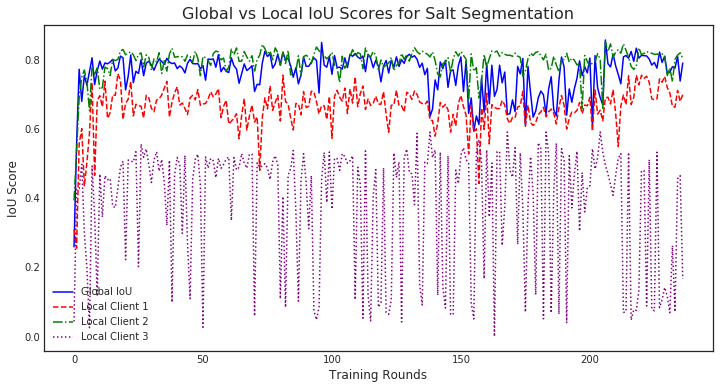

In [59]:


# X-axis values (assuming IoU values over rounds/steps)
x = np.arange(len(df_ious))

# Plotting with different line styles
plt.figure(figsize=(12, 6))
plt.plot(x, df_ious.globaliou, linestyle='-', color='b', label='Global IoU')       # Solid line
plt.plot(x, df_ious.list1, linestyle='--', color='r', label='Local Client 1')      # Dashed line
plt.plot(x, df_ious.list2, linestyle='-.', color='g', label='Local Client 2')      # Dash-dot line
plt.plot(x, df_ious.list3, linestyle=':', color='purple', label='Local Client 3')  # Dotted line

# Labels and title
plt.xlabel("Training Rounds", fontsize=12)
plt.ylabel("IoU Score", fontsize=12)
plt.title("Global vs Local IoU Scores for Salt Segmentation", fontsize=16)
plt.legend()
#plt.grid(True)

# Show the plot
plt.show()


In [37]:
model.compile(loss=bce_dice_loss, optimizer=sgd, metrics=[my_iou_metric])

In [ ]:

epochs = 60
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
batch_size = 32
swa = SWA('./u-tgs_seam-all.h5',30)
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=snapshot.get_callbacks(),shuffle=True,verbose=2)

In [32]:
from keras.models import load_model
model1 = load_model('/kaggle/input/fednetsaltv1/keras/default/1/fed_fg_w_avg_b7_v1.model', custom_objects={'my_iou_metric': my_iou_metric})

KeyError: "Unable to open object (object 'block4j_activation' doesn't exist)"

In [31]:
# Load best model
try:
    global_model.load_weights('/kaggle/input/fednetsaltv1/keras/default/1/fed_fg_w_avg_b7_v1.model')
    print('using swa weight model')
except:
    model.load_weights('./u_tgs_seam.model')

NameError: name 'model' is not defined

In [5]:
model2.load_weights('/kaggle/input/unet_models_trained/keras/default/1/efficientnetb7.model')
#model2.load_weights('/kaggle/input/seam_models/keras/default/1/efficientnetb7-unet-seam.model')

#model1.load_weights('/kaggle/input/seam_models/keras/default/1/efficientnetb7-linknet seam.model')
#model3.load_weights('/kaggle/input/xception-seam/keras/default/1/xception_seam.h5')

In [78]:
from keras.models import clone_model

# Assume model1 and model2 are your two Keras models with the same architecture

# Step 1: Create a new model with the same architecture
average_model = clone_model(model)
average_model.set_weights([0.5 * (w1 + w2) for w1, w2 in zip(model.get_weights(), model2.get_weights())])

# The weights of average_model are now the average of model1 and model2


In [27]:
def predict_result(model,x_test,img_size_target,batch_size): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test],batch_size=batch_size).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict([x_test_reflect],batch_size=batch_size).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [28]:

preds_valid = predict_result(global_model,x_valid,img_size_target,32)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in y_valid])

In [35]:
preds_valid = predict_result(model1,x_test1,img_size_target,32)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in y_test1])

In [68]:
#preds_valid3 = predict_result(model3,x_test,img_size_target,32)
#preds_valid3 = np.array([downsample(x) for x in preds_valid3])
#y_test_ori = np.array([downsample(x) for x in y_test])

In [65]:
#y_test.shape

(1400, 128, 128, 1)

In [28]:
y_test.shape

(546, 128, 128, 1)

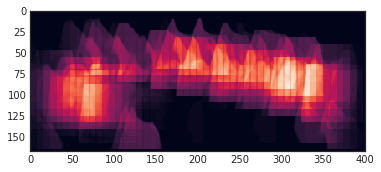

In [50]:
plt.imshow(reconstructed_img)

In [42]:
preds = (preds_valid > 0.486).astype(int) 

In [53]:
x_valid_ori = np.array([downsample(x) for x in x_valid])

In [29]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [30]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

A Jupyter Widget

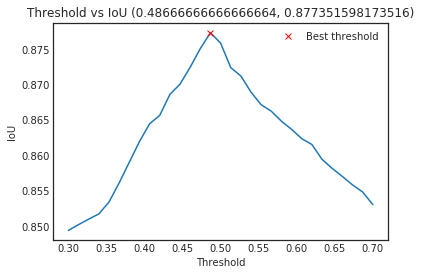

In [31]:
#fedsaltnet valid
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [32]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metrics(preds_valid, y_valid_ori, threshold=0.5):
  """Calculates precision, recall, F1-score, and accuracy for binary classification.

  Args:
    preds_valid: Predicted probabilities.
    y_valid_ori: Original probability maps.
    threshold: Threshold for binarizing predictions.

  Returns:
    A tuple of precision, recall, F1-score, and accuracy.
  """

  y_valid_bin = np.where(y_valid_ori > threshold, 1, 0)
  y_valid_flat = y_valid_bin.flatten()
  preds_valid_bin_flat = (preds_valid > threshold).astype(np.uint8).flatten()

  precision = precision_score(y_valid_flat, preds_valid_bin_flat)
  recall = recall_score(y_valid_flat, preds_valid_bin_flat)
  f1 = f1_score(y_valid_flat, preds_valid_bin_flat)
  accuracy = accuracy_score(y_valid_flat, preds_valid_bin_flat)

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)
  print("Accuracy:", accuracy)

  return precision, recall, f1, accuracy

In [33]:
calculate_metrics(preds_valid, y_valid_ori, threshold=0.486)

Precision: 0.9760897039576211
Recall: 0.8735224341946131
F1-score: 0.9219622174897117
Accuracy: 0.9753435400504651


(0.9760897039576211,
 0.8735224341946131,
 0.9219622174897117,
 0.9753435400504651)

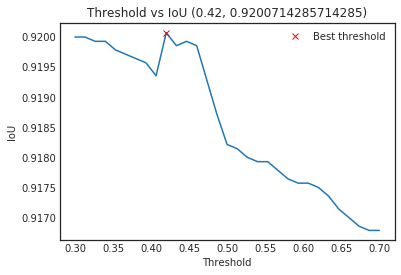

In [70]:
#f3 xception
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

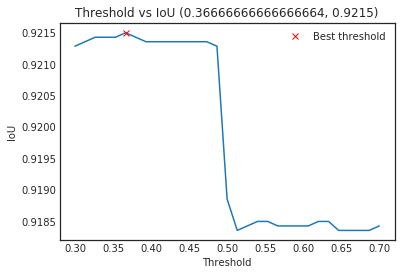

In [38]:
#f3 unet
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

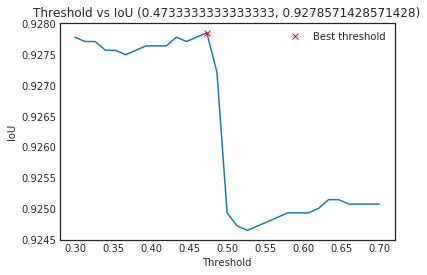

In [55]:
#f3 linknet
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

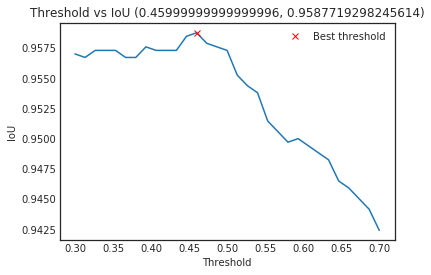

In [41]:
#resnet50 SEAM
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

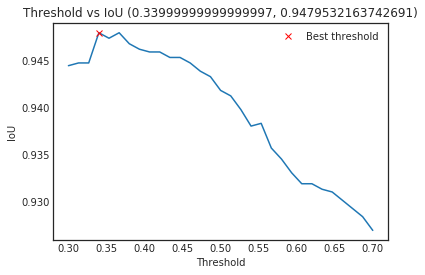

In [145]:
#effLinknet SEAM
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

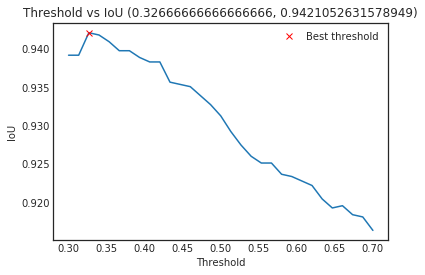

In [141]:
#effUNet SEAM
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

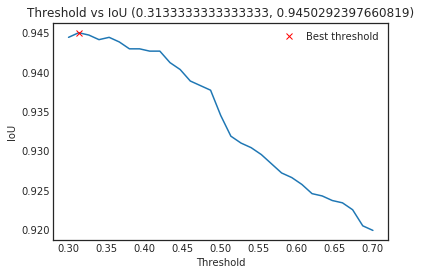

In [86]:
#XceptionNet SEAM
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

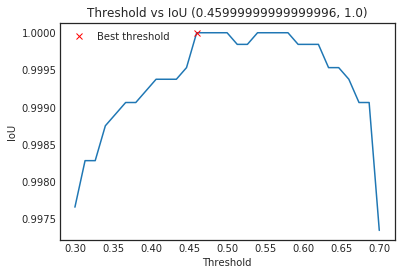

In [33]:
#XceptionNet SEAM
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

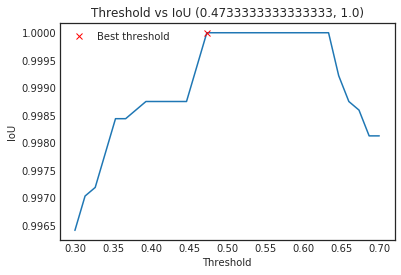

In [88]:
#UNET-EFFNETb7
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

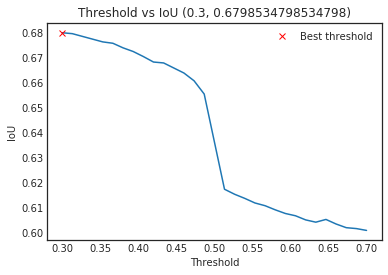

In [29]:
#LINKNET-EFFNETb7
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [8]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metrics(preds_valid_bin_flat, y_valid_ori, threshold=0.5):
  """Calculates precision, recall, F1-score, and accuracy for binary classification.

  Args:
    preds_valid: Predicted probabilities.
    y_valid_ori: Original probability maps.
    threshold: Threshold for binarizing predictions.

  Returns:
    A tuple of precision, recall, F1-score, and accuracy.
  """

  y_valid_bin = np.where(y_valid_ori > threshold, 1, 0)
  y_valid_flat = y_valid_bin.flatten()
  preds_valid_bin_flat = preds_valid_bin_flat.astype(np.uint8).flatten()
  #preds_valid
  precision = precision_score(y_valid_flat, preds_valid_bin_flat)
  recall = recall_score(y_valid_flat, preds_valid_bin_flat)
  f1 = f1_score(y_valid_flat, preds_valid_bin_flat)
  accuracy = accuracy_score(y_valid_flat, preds_valid_bin_flat)

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)
  print("Accuracy:", accuracy)

  return precision, recall, f1, accuracy


In [9]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metrics(preds_valid, y_valid_ori, threshold=0.5):
  """Calculates precision, recall, F1-score, and accuracy for binary classification.

  Args:
    preds_valid: Predicted probabilities.
    y_valid_ori: Original probability maps.
    threshold: Threshold for binarizing predictions.

  Returns:
    A tuple of precision, recall, F1-score, and accuracy.
  """

  y_valid_bin = np.where(y_valid_ori > threshold, 1, 0)
  y_valid_flat = y_valid_bin.flatten()
  preds_valid_bin_flat = (preds_valid > threshold).astype(np.uint8).flatten()

  precision = precision_score(y_valid_flat, preds_valid_bin_flat)
  recall = recall_score(y_valid_flat, preds_valid_bin_flat)
  f1 = f1_score(y_valid_flat, preds_valid_bin_flat)
  accuracy = accuracy_score(y_valid_flat, preds_valid_bin_flat)

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)
  print("Accuracy:", accuracy)

  return precision, recall, f1, accuracy

In [41]:
preds_valid1.shape

(1400, 128, 128)

In [57]:
#all dataset linknet

In [48]:
calculate_metrics(preds_valid, y_valid_ori, threshold=0.513)

Precision: 0.9609940417296945
Recall: 0.91264745886878
F1-score: 0.9361969938139169
Accuracy: 0.9690801146946377


(0.9609940417296945, 0.91264745886878, 0.9361969938139169, 0.9690801146946377)

## Testing all

In [67]:
### TGS

In [48]:
preds_valid = predict_result(global_model,x_test1,img_size_target,32)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_test_ori = np.array([downsample(x) for x in y_test1])

In [49]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_test_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

A Jupyter Widget

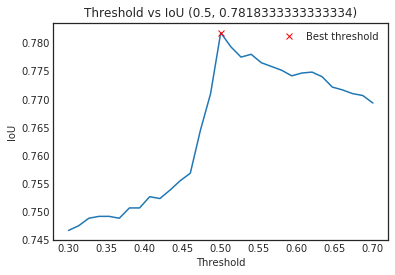

In [50]:
#TGS test
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [51]:

calculate_metrics(preds_valid, y_test_ori, threshold=0.5)

Precision: 0.9696402546947297
Recall: 0.8413842816751204
F1-score: 0.9009707519644492
Accuracy: 0.9540953501290723


(0.9696402546947297,
 0.8413842816751204,
 0.9009707519644492,
 0.9540953501290723)

In [75]:
### F3

In [76]:
preds_valid = predict_result(model,x_test2,img_size_target,32)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_test_ori = np.array([downsample(x) for x in y_test2])

In [77]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_test_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

A Jupyter Widget

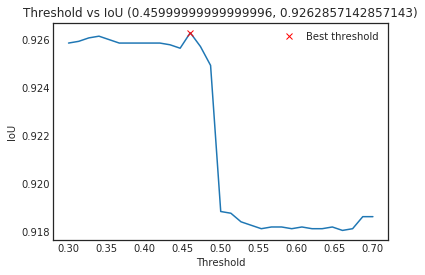

In [78]:
#LINKNET-EFFNETb7
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [79]:

calculate_metrics(preds_valid, y_test_ori, threshold=0.459)

Precision: 0.8560566429368698
Recall: 0.55825960093321
F1-score: 0.6758061953024713
Accuracy: 0.9761442855742434


(0.8560566429368698, 0.55825960093321, 0.6758061953024713, 0.9761442855742434)

In [93]:
#SEAm

In [105]:
preds_valid = predict_result(model,x_test3,img_size_target,32)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_test_ori = np.array([downsample(x) for x in y_test3])

In [106]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_test_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

A Jupyter Widget

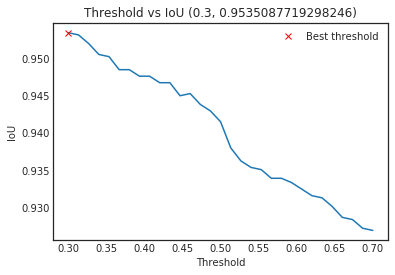

In [107]:
#LINKNET-EFFNETb7
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [108]:

calculate_metrics(preds_valid, y_test_ori, threshold=0.3)

Precision: 0.9882688246819471
Recall: 0.9838652372713791
F1-score: 0.9860621145811562
Accuracy: 0.9886457640031852


(0.9882688246819471,
 0.9838652372713791,
 0.9860621145811562,
 0.9886457640031852)

In [40]:
test_img = np.array(load_img("/kaggle/input/seam-valid/test_img.png", grayscale=True))/ 255.0
#test_img = np.flip(test_img, axis=1)
test_mask = np.array(load_img("/kaggle/input/seam-valid/test_mask.png", grayscale=True))/ 255.0
#test_mask = np.flip(test_mask, axis=1)

In [47]:
test_img = np.array(load_img("/kaggle/input/f3-valid/test_imgf3.png", grayscale=True))/ 255.0
#test_img = np.flip(test_img, axis=1)
test_mask = np.array(load_img("/kaggle/input/f3-valid/test_maskf3.png", grayscale=True))/ 255.0
#test_mask = np.flip(test_mask, axis=1)

In [48]:

test_img = np.array(load_img("//kaggle/input/landmasstest/image_1599.png", grayscale=True))/ 255.0


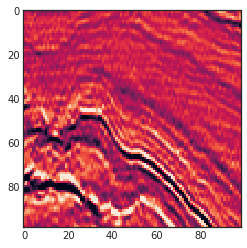

In [49]:
plt.imshow(test_img)

In [50]:
im = cv2.resize(test_img, (128, 128))
im = np.expand_dims(im, axis=-1)

In [31]:
im.shape

(128, 128, 9)

In [45]:
pred[0].shape

(128, 128, 1)

In [51]:
im=np.repeat(im, 3, axis=-1)
pred = model2.predict(np.expand_dims(im, axis=0))

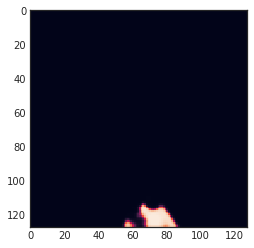

In [52]:
plt.imshow(np.squeeze(pred[0]))

In [48]:
import numpy as np
import cv2

def predict_large_image(test_img, model, window_size=50, step=12, upsample_size=128):
    height, width = test_img.shape[:2]
    # Create an empty array for the full mask and weight mask
    predicted_mask = np.zeros((height, width), dtype=np.float32)
    #weight_mask = np.zeros((height, width), dtype=np.float32)  # To handle overlapping regions

    # Slide over the test image
    for i in range(0, height - window_size + 1, step):
        for j in range(0, width - window_size + 1, step):
            # Extract the window
            patch = test_img[i:i + window_size, j:j + window_size]
            
            # Resize and add channels to match model input shape
            patch_resized = cv2.resize(patch, (upsample_size, upsample_size))
            patch_input = np.repeat(patch_resized[..., np.newaxis], 3, axis=-1)  # (128, 128, 3)

            # Predict mask for this patch
            patch_pred = model.predict(patch_input[np.newaxis, ...])[0, ..., 0]  # (128, 128, 1)

            # Resize back to (101, 101) to fit into the original mask
            patch_pred_resized = cv2.resize(patch_pred, (window_size, window_size))

            # Place the predicted mask back onto the full mask
            predicted_mask[i:i + window_size, j:j + window_size] += patch_pred_resized
            #weight_mask[i:i + window_size, j:j + window_size] += 1

    # Avoid division by zero by setting weights of 0 to 1 (only in weight_mask)
    #weight_mask[weight_mask == 0] = 1

    # Average the overlapping regions
    #predicted_mask /= weight_mask
    return predicted_mask

# Usage
# Assuming test_img is your input image and model is your trained model
predicted_mask2 = predict_large_image(test_img, model1)

# Convert to binary mask if needed
#predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Display or save the predicted mask
#cv2.imwrite('predicted_mask.png', predicted_mask_binary * 255)  # Save as binary mask image


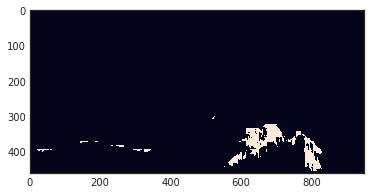

In [51]:
plt.imshow(predicted_mask_binary)

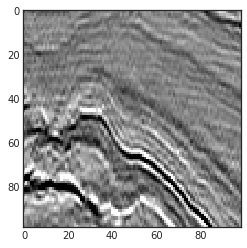

In [77]:
plt.imshow(test_img, cmap='gray')

In [50]:
predicted_mask_binary = (predicted_mask2 > 0.7).astype(np.uint8)

In [43]:
#without swa
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(test_mask, np.int32(predicted_mask2 > threshold)) for threshold in tqdm_notebook(thresholds)])

A Jupyter Widget

In [46]:
ious

array([0.88630952, 0.88809524, 0.88928571, 0.89166667, 0.89107143,
       0.89047619, 0.89821429, 0.90416667, 0.90416667, 0.90595238,
       0.90595238, 0.90714286, 0.9077381 , 0.9077381 , 0.90833333,
       0.90833333, 0.90833333, 0.90892857, 0.90892857, 0.90952381,
       0.91011905, 0.91130952, 0.91190476, 0.91130952, 0.91130952,
       0.91190476, 0.9125    , 0.9125    , 0.91190476, 0.91309524,
       0.91369048])

A Jupyter Widget

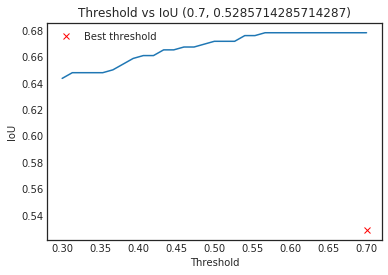

In [49]:
#saltfesnet seam
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(test_mask, np.int32(predicted_mask2 > threshold)) for threshold in tqdm_notebook(thresholds)]) 
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

A Jupyter Widget

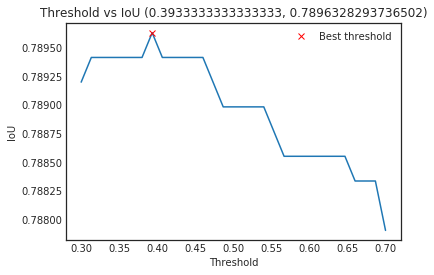

In [97]:
#linknetallf3
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(test_mask, np.int32(predicted_mask2 > threshold)) for threshold in tqdm_notebook(thresholds)]) 
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

A Jupyter Widget

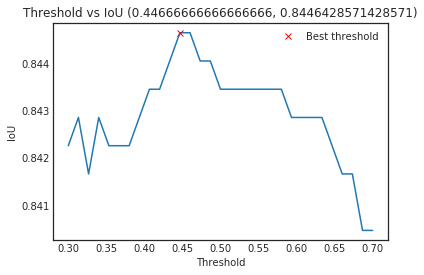

In [83]:
#linknetallseam
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(test_mask, np.int32(predicted_mask2 > threshold)) for threshold in tqdm_notebook(thresholds)]) 
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

A Jupyter Widget

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



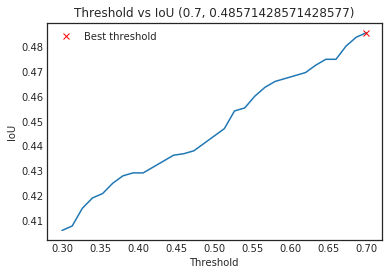

In [67]:
#effnetb7-link
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(test_mask, np.int32(predicted_mask2 > threshold)) for threshold in tqdm_notebook(thresholds)]) 
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

A Jupyter Widget

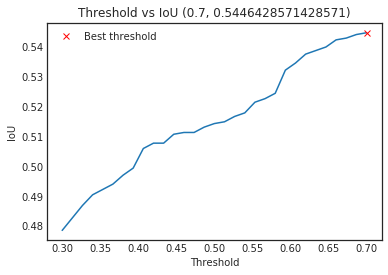

In [52]:
#effnetb7-unet
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(test_mask, np.int32(predicted_mask2 > threshold)) for threshold in tqdm_notebook(thresholds)]) 
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

A Jupyter Widget

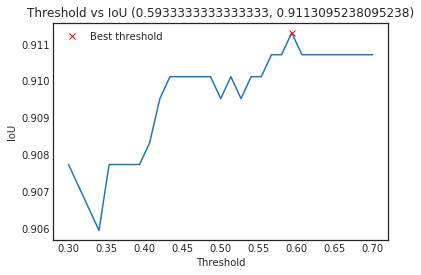

In [40]:
#xceptionnet
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(test_mask, np.int32(predicted_mask > threshold)) for threshold in tqdm_notebook(thresholds)]) 
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

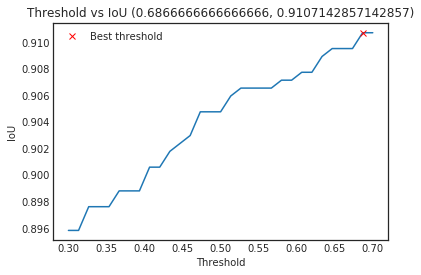

In [121]:
#resnet
threshold_best_index = np.argmax(ious) 
iou_best =#without swa
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(test_mask, np.int32(predicted_mask > threshold)) for threshold in tqdm_notebook(thresholds)]) ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

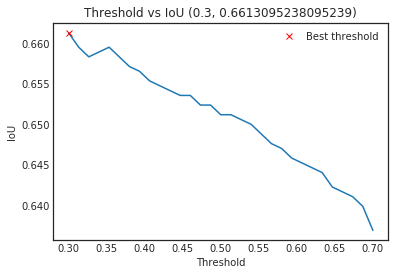

In [71]:
#efficientnet link
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

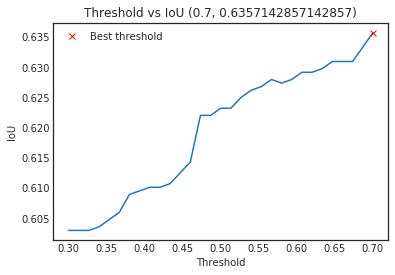

In [155]:
#efficientnet unet
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

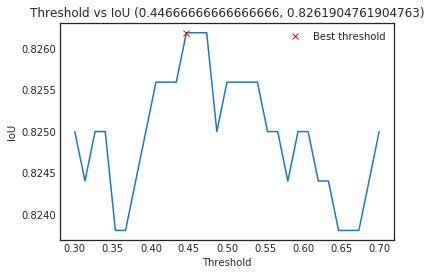

In [238]:
#efficientnet unet_updated window
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

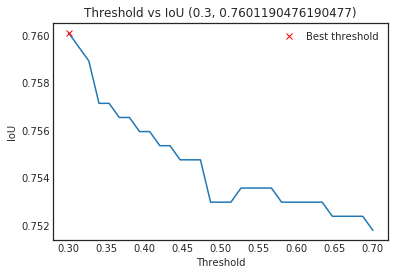

In [113]:
#test
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [75]:
import numpy as np
from tqdm import tqdm_notebook

# Assuming preds_valid1, preds_valid2, preds_valid3, preds_valid4 are the predictions from the models
# and y_valid_ori is the ground truth

# Stack predictions from models
all_preds = np.stack([preds_valid1, preds_valid2, preds_valid3], axis=-1)

# Average the predictions to create ensemble predictions
#ensemble_preds = np.mean(all_preds, axis=-1)
# Assuming weights are calculated based on model performance
weights = [0.2, 0.4, 0.1]  # Example weights
#weighted_preds = all_preds * weights[:, np.newaxis, np.newaxis]
#ensemble_preds = np.sum(weighted_preds, axis=-1)
# Weighted averaging
#ensemble_preds = np.argmax(all_preds, axis=-1)
ensemble_preds = np.average(all_preds, axis=-1, weights=weights)
# Define thresholds
thresholds = np.linspace(0.3, 0.7, 31)

# Compute IOU for different thresholds
ious = []
for threshold in tqdm_notebook(thresholds):
    # Convert ensemble predictions to binary using the current threshold
    binary_preds = (ensemble_preds > threshold).astype(int)
    # Compute IOU
    iou = iou_metric_batch(y_test_ori, binary_preds)
    ious.append(iou)

# Find the best threshold
ious = np.array(ious)
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'Best IOU: {iou_best}')
print(f'Best Threshold: {threshold_best}')


A Jupyter Widget


Best IOU: 0.9260714285714285
Best Threshold: 0.3


In [53]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc

def calculate_metrics(preds_valid, y_valid_ori, threshold=0.5):
    """Calculates precision, recall, F1-score, accuracy, and mAP for binary classification.

    Args:
        preds_valid: Predicted probabilities.
        y_valid_ori: Original probability maps.
        threshold: Threshold for binarizing predictions.

    Returns:
        A tuple of precision, recall, F1-score, accuracy, and mAP.
    """
    # Binarize the ground truth
    y_valid_bin = np.where(y_valid_ori > threshold, 1, 0)
    y_valid_flat = y_valid_bin.flatten()
    preds_valid_bin_flat = (preds_valid > threshold).astype(np.uint8).flatten()

    # Calculate precision, recall, F1-score, and accuracy
    precision = precision_score(y_valid_flat, preds_valid_bin_flat)
    recall = recall_score(y_valid_flat, preds_valid_bin_flat)
    f1 = f1_score(y_valid_flat, preds_valid_bin_flat)
    accuracy = accuracy_score(y_valid_flat, preds_valid_bin_flat)

    # Calculate precision-recall curve for mAP
    precision_vals, recall_vals, _ = precision_recall_curve(y_valid_flat, preds_valid.flatten())
    mAP = auc(recall_vals, precision_vals)  # Area under the precision-recall curve

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Accuracy:", accuracy)
    print("mAP (Mean Average Precision):", mAP)

    return precision, recall, f1, accuracy, mAP


In [58]:
#seam
calculate_metrics(predicted_mask2, test_mask, threshold=0.7)

Precision: 0.6619852590664076
Recall: 0.9618007458710709
F1-score: 0.7842140700679829
Accuracy: 0.8521577380952381


(0.6619852590664076,
 0.9618007458710709,
 0.7842140700679829,
 0.8521577380952381)

In [98]:
#f3 linkall
calculate_metrics(predicted_mask2, test_mask, threshold=0.39)

Precision: 0.8617959845486194
Recall: 0.6478221903566947
F1-score: 0.7396447282252784
Accuracy: 0.9711069171248634


(0.8617959845486194,
 0.6478221903566947,
 0.7396447282252784,
 0.9711069171248634)

In [84]:
#seam linkall
calculate_metrics(predicted_mask2, test_mask, threshold=0.446)

Precision: 0.9853794246478039
Recall: 0.8868939797549281
F1-score: 0.9335464333781964
Accuracy: 0.9647321428571428


(0.9853794246478039,
 0.8868939797549281,
 0.9335464333781964,
 0.9647321428571428)

In [98]:
calculate_metrics(ensemble_preds, y_test_ori, threshold=0.35)

Precision: 0.8055497199445384
Recall: 0.7801375040495303
F1-score: 0.7926399839716196
Accuracy: 0.9817377147898665
mAP (Mean Average Precision): 0.8154632288511775


(0.8055497199445384,
 0.7801375040495303,
 0.7926399839716196,
 0.9817377147898665,
 0.8154632288511775)

In [42]:
#resnet
iou_metric_batch(test_mask, np.int32(predicted_mask2 > 0.44))

0.9113095238095238

In [233]:
test_mask.shape

(168, 400)

In [85]:
preds = (predicted_mask2 > 0.45).astype(int) 

In [62]:
preds.shape 

(3, 128, 128)

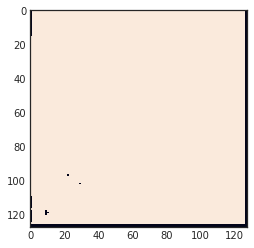

In [80]:
plt.imshow(preds)

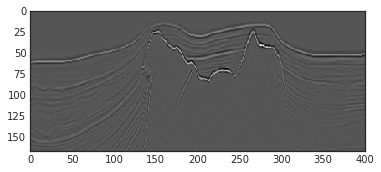

In [120]:
plt.imshow(test_img, cmap='gray')

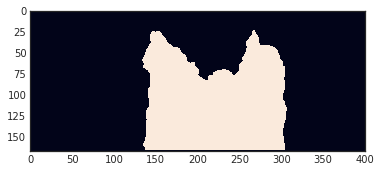

In [118]:
plt.imshow(test_mask)

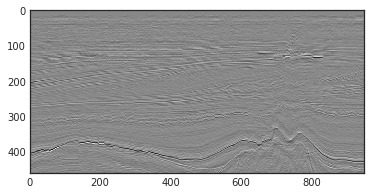

In [24]:
plt.imshow(test_img, cmap='gray')

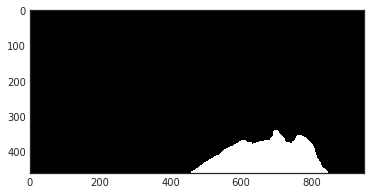

In [25]:
plt.imshow(test_mask, cmap='gray')

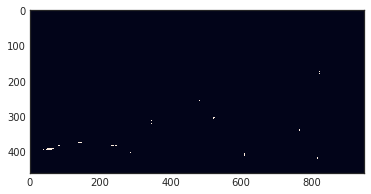

In [73]:
#f3-linkall
plt.imshow(preds)

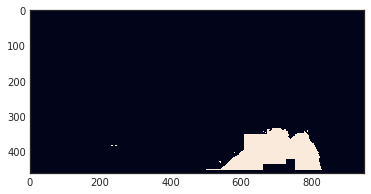

In [31]:
#f3-linkall
plt.imshow(preds)

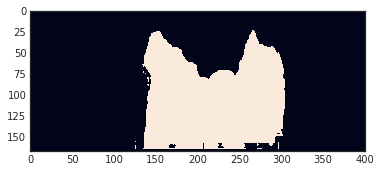

In [56]:
#seam-tgs
plt.imshow(preds)

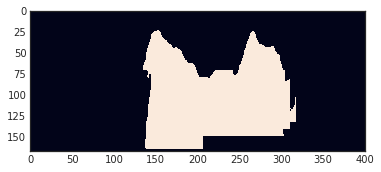

In [87]:
#resnet
plt.imshow(preds)

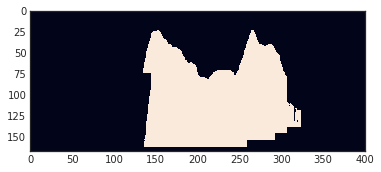

In [103]:
#efficientnet linknet tgs encoder
plt.imshow(preds)

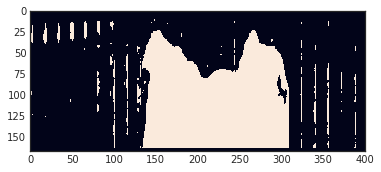

In [41]:
#efficientnet unet tgs encoder
plt.imshow(preds)

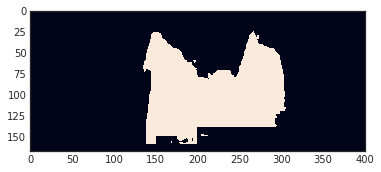

In [115]:
#test
plt.imshow(preds)

In [30]:
preds = (preds_valid > 0.3).astype(int) 

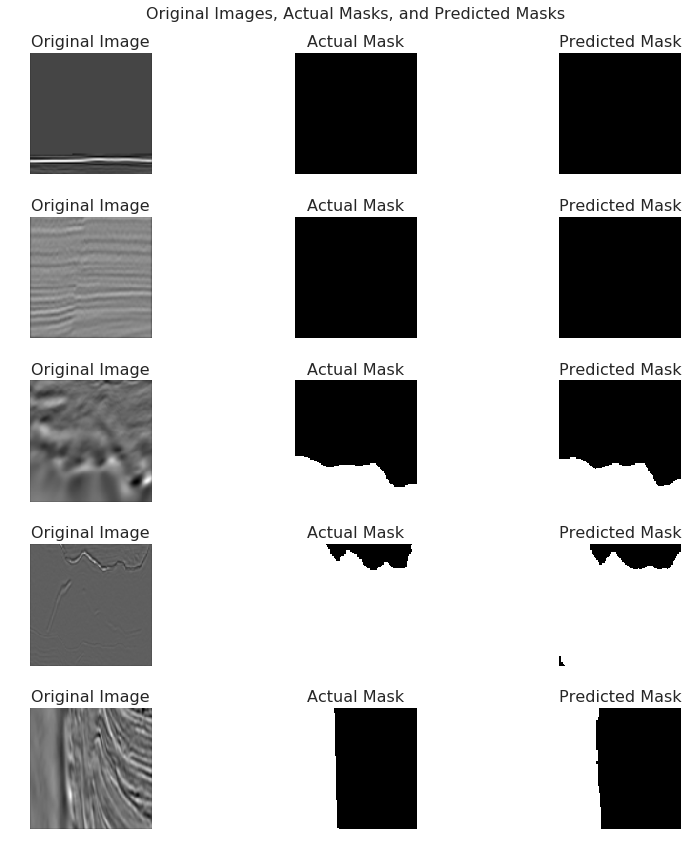

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to display
num_samples = 5

# Randomly select indices
indices = np.random.choice(range(x_valid.shape[0]), num_samples, replace=False)

# Set up the figure with subplots
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 12))
fig.suptitle('Original Images, Actual Masks, and Predicted Masks', fontsize=16)

for i, idx in enumerate(indices):
    # Original image
    axes[i, 0].imshow(x_valid[idx])
    axes[i, 0].set_title("Original Image",fontsize=16)
    axes[i, 0].axis("off")
    
    # Actual mask
    axes[i, 1].imshow(y_valid[idx].squeeze(), cmap='gray')
    axes[i, 1].set_title("Actual Mask",fontsize=16)
    axes[i, 1].axis("off")
    
    # Predicted mask
    axes[i, 2].imshow(preds[idx], cmap='gray')
    axes[i, 2].set_title("Predicted Mask",fontsize=16)
    axes[i, 2].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


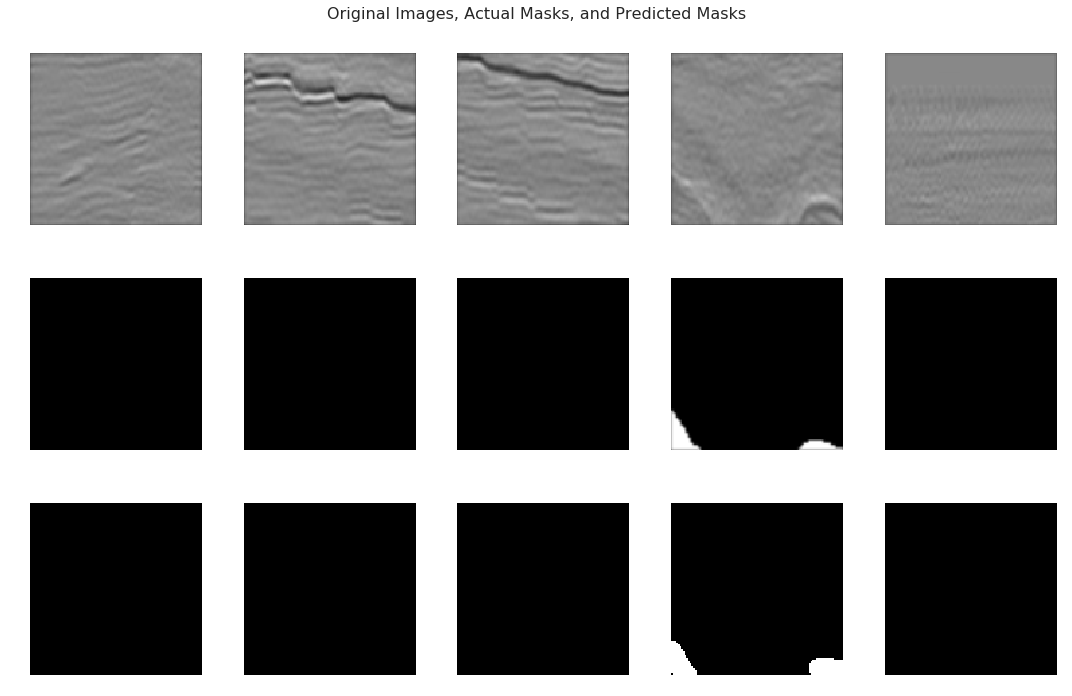

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to display
num_samples = 5

# Randomly select indices
indices = np.random.choice(range(x_test.shape[0]), num_samples, replace=False)

# Set up the figure with subplots
fig, axes = plt.subplots(3, num_samples, figsize=(15, 10))
fig.suptitle('Original Images, Actual Masks, and Predicted Masks', fontsize=16)

# Loop through each sample index
for i, idx in enumerate(indices):
    # Original image in the first row
    axes[0, i].imshow(x_test[idx])
    #axes[0, i].set_title("Original Image" if i == 0 else "")
    axes[0, i].axis("off")
    
    # Actual mask in the second row
    axes[1, i].imshow(y_test[idx].squeeze(), cmap='gray')
    #axes[1, i].set_title("Actual Mask" if i == 0 else "")
    axes[1, i].axis("off")
    
    # Predicted mask in the third row
    axes[2, i].imshow(preds[idx], cmap='gray')
    #axes[2, i].set_title("Predicted Mask" if i == 0 else "")
    axes[2, i].axis("off")

# Adjust layout to improve spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [153]:
calculate_metrics(preds_valid, y_valid_ori)

NameError: name 'calculate_metrics' is not defined

In [32]:
# Print sample of binarized predictions and ground truth
print("Binarized y_valid:", y_valid_ori[:5]) # Show first 5 elements
print("Binarized predictions:", preds_valid_bin_flat[:5])


NameError: name 'x_valid_ori' is not defined

In [ ]:
from IPython.display import FileLink
FileLink(r'coverage.csv')

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import img_to_array, load_img

def grad_cam(model, img, layer_name):
  x = np.expand_dims(img, axis=0)
  x = tf.convert_to_tensor(x) 

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer(layer_name)
    with tf.GradientTape() as tape:
      last_conv_output, preds = model(x)
      class_idx = np.argmax(preds[0])
      class_output = preds[:, class_idx]
    grads = tape.gradient(class_output, last_conv_output)

  pooled_grads = np.mean(grads, axis=(0, 1, 2))
  last_conv_output = last_conv_output[0]

  heatmap = np.zeros(last_conv_output.shape[0:2])
  for i in range(len(pooled_grads)):
    heatmap += pooled_grads[i] * last_conv_output[:, :, i]

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  # Display the heatmap on the original image
  plt.matshow(heatmap)
  plt.show()

  img = np.array(img)
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
  plt.imshow(superimposed_img)
  plt.show()



In [ ]:
# Example usage:
layer_name = 'top_conv'  # Replace with the desired layer name
layer_name = get_last_conv_layer_name(model) 
grad_cam(model, x_train[0], layer_name)

In [ ]:
import os


import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:

model_builder = tf.keras.applications.Xception
img_size = (128, 128)
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions
last_conv_layer_name = "block14_sepconv2_act"



In [ ]:
def get_img_array(img, size):
    # `img` is a PIL image of size 299x299
    #img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    #array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    
    array = np.expand_dims(img, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Convert the image array to a TensorFlow tensor
    img_array = tf.convert_to_tensor(img_array)

    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = tf.keras.models.Model(
        inputs=model.input,  # Use model.input instead of [model.inputs]
        outputs=[last_conv_layer.output, model.output]
    )

    # Record the gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        # Get the class score
        class_channel = preds[:, pred_index]

    # Compute the gradient of the class score with respect to the last conv layer output
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the mean intensity of the gradients for each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the corresponding gradient
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply the ReLU activation to the heatmap
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()



In [ ]:

img_array = preprocess_input(get_img_array(x_train[0].astype('float32'), size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])



In [ ]:
# Generate class activation heatmap
#tf.config.run_functions_eagerly(True)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
keras.__version__

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

# Load the EfficientNetB7 model with ImageNet weights
model = keras.applications.EfficientNetB7(weights='imagenet')

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Use the top predicted class
        class_channel = preds[0][pred_index]  # Get the class score

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Get the last convolutional layer output
    last_conv_layer_output = last_conv_layer_output[0]

    # Multiply each channel by the mean of the gradients
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)  # Remove dimensions of size 1

    # Apply ReLU to the heatmap and normalize
    heatmap = tf.maximum(heatmap, 0)  # ReLU
    heatmap /= tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()

# Display heatmap overlaid on the original image
def display_heatmap(heatmap, original_image):
    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8 format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map
    superimposed_img = heatmap * 0.4 + original_image  # Overlay heatmap on image
    plt.imshow(superimposed_img / 255)  # Display the image
    plt.axis('off')
    plt.show()

# Assuming img_array is your pre-loaded image array and original_image is the raw image array
# Example: img_array = np.array(your_preloaded_image)

# Generate Grad-CAM heatmap
last_conv_layer_name = 'top_conv'  # Last conv layer of EfficientNetB7
heatmap = make_gradcam_heatmap(x_train[0], model, last_conv_layer_name)

# Assuming original_image is the image read using cv2 or any other method
# Make sure original_image is in RGB format and has the same shape as the preloaded image
# Example: original_image = cv2.imread('path_to_your_image.jpg')
# Convert BGR to RGB if necessary
# original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Display the heatmap overlaid on the original image
display_heatmap(heatmap, original_image)


In [137]:
model4.load_weights('/kaggle/input/linkeffnet/keras/default/1/link-efficientnetb7.h5')
model.load_weights('/kaggle/input/unet_models_trained/keras/default/1/efficientnetb7.model')

In [152]:
model.load_weights('/kaggle/input/unet_models_trained/keras/default/1/efficientnetb7.model')

In [ ]:
from keras.models import Model, load_model, save_model
model2.load_weights('/kaggle/input/unet_models_trained/keras/default/1/Xception_unet.model')

In [ ]:
model3.load_weights('/kaggle/input/linkeffnet/keras/default/1/link-efficientnetb7.h5')

In [ ]:
import os
import cv2
import numpy as np

# Set the path to the folder
folder_path = '/kaggle/input/landmasstest'

# Initialize an empty list to store images
images = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust extensions as needed
        # Load image
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Use IMREAD_GRAYSCALE if images are grayscale
        
        # Optionally resize if needed
        img_resized = cv2.resize(img, (128, 128))
        # img = cv2.resize(img, (desired_width, desired_height))
        
        # Append image to list
        images.append(img_resized)

# Convert the list to a NumPy array
images_array = np.array(images)

print("Loaded images array shape:", images_array.shape)


In [54]:
import os
import cv2
import numpy as np

# Set the path to the folder
folder_path = '/kaggle/input/landmasstest'

# Initialize an empty list to store images
images = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust extensions as needed
        # Load image
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Use IMREAD_GRAYSCALE if images are grayscale
        
        # Resize the image to 128x128
        img_resized = cv2.resize(img, (128, 128))
        
        # Append the resized image to the list
        images.append(img_resized)

# Convert the list to a NumPy array
images_array = np.array(images)

print("Loaded images array shape:", images_array.shape)


Loaded images array shape: (3, 128, 128, 3)


In [55]:
images_array[0].shape

(128, 128, 3)

In [ ]:
import numpy as np
import cv2
import os

def convolve_and_average_predictions(original_image, model, img_size_target, patch_size=(128, 128), stride=32):
    # Prepare an empty mask for the predictions
    pred_mask = np.zeros(original_image.shape[:2], dtype=np.float32)  # Shape of the mask is (height, width)
    count_mask = np.zeros(original_image.shape[:2], dtype=np.float32)  # To count how many times each pixel is predicted

    h, w, _ = original_image.shape
    for y in range(0, h - patch_size[0] + 1, stride):
        for x in range(0, w - patch_size[1] + 1, stride):
            # Extract the patch from the original image
            patch = original_image[y:y + patch_size[0], x:x + patch_size[1]]
            patch_resized = cv2.resize(patch, img_size_target)  # Resize the patch to the model's input size

            # Predict the mask for the patch
            pred = predict_result(model, np.array([patch_resized]), img_size_target, batch_size=32)
            pred_mask[y:y + patch_size[0], x:x + patch_size[1]] += pred[0]  # Assuming pred is shaped (1, height, width, 1)
            count_mask[y:y + patch_size[0], x:x + patch_size[1]] += 1  # Increment the count for each patch

    # Average the predictions
    avg_pred_mask = pred_mask / count_mask
    avg_pred_mask = (avg_pred_mask > 0.5133).astype(int)  # Convert to binary mask using the threshold

    return avg_pred_mask

# Set the path to the folder containing original images
folder_path = '/kaggle/input/landmasstest'

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust extensions as needed
        img_path = os.path.join(folder_path, filename)
        original_image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load the original image

        # Use the function to get the averaged mask prediction
        final_mask_prediction = convolve_and_average_predictions(original_image, model, img_size_target, patch_size=(128, 128), stride=32)
        
        # Optionally, save or display the final mask
        # For display
        cv2.imshow('Final Mask', final_mask_prediction * 255)  # Convert to displayable format
        cv2.waitKey(0)  # Wait until a key is pressed
        cv2.destroyAllWindows()


In [58]:
preds_valid4 = predict_result(model1,images_array,img_size_target,32)
#preds_valid4 = np.array([downsample(x) for x in preds_valid4])

In [ ]:
binary_preds4 =  (preds_valid4 > 0.46).astype(int) 

In [ ]:
binary_preds4.shape

In [ ]:
preds_valid = predict_result(model1,x_valid,img_size_target,32)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in y_valid])

In [ ]:
preds_valid2 = predict_result(model2,x_valid,img_size_target,32)
preds_valid2 = np.array([downsample(x) for x in preds_valid2])
#y_valid_ori = np.array([downsample(x) for x in y_valid])

In [ ]:
preds_valid3 = predict_result(model3,x_valid,img_size_target,32)
preds_valid3 = np.array([downsample(x) for x in preds_valid3])
#y_valid_ori = np.array([downsample(x) for x in y_valid])

In [ ]:
binary_preds1 =  (preds_valid > 0.51).astype(int) 
binary_preds2 =  (preds_valid2 > 0.54).astype(int)  
binary_preds3 =  (preds_valid3 > 0.366).astype(int)   

In [ ]:
from scipy.stats import mode
# Stack predictions
all_preds = np.stack([ binary_preds1, binary_preds2, binary_preds2], axis=-1)

# Apply majority voting
# The result will be the mode along the last axis
ensemble_preds,_ = mode(all_preds, axis=-1)

# Since mode returns a 2D array with mode values and counts, we need to extract the first element
ensemble_preds = ensemble_preds.squeeze()  # Remove the last dimension with single value

# Check shape of the ensemble predictions
print(ensemble_preds.shape)

In [ ]:
iou_metric_batch(y_valid_ori, ensemble_preds)

In [102]:
import numpy as np
from tqdm import tqdm_notebook

# Assuming preds_valid1, preds_valid2, preds_valid3, preds_valid4 are the predictions from the models
# and y_valid_ori is the ground truth

# Stack predictions from models
all_preds = np.stack([preds_valid1, preds_valid2, preds_valid3], axis=-1)

# Average the predictions to create ensemble predictions
#ensemble_preds = np.mean(all_preds, axis=-1)
# Assuming weights are calculated based on model performance
weights = [0.1, 0.3, 0.3]  # Example weights
#weighted_preds = all_preds * weights[:, np.newaxis, np.newaxis]
#ensemble_preds = np.sum(weighted_preds, axis=-1)
# Weighted averaging
#ensemble_preds = np.argmax(all_preds, axis=-1)
ensemble_preds = np.average(all_preds, axis=-1, weights=weights)
# Define thresholds
thresholds = np.linspace(0.3, 0.7, 31)

# Compute IOU for different thresholds
ious = []
for threshold in tqdm_notebook(thresholds):
    # Convert ensemble predictions to binary using the current threshold
    binary_preds = (ensemble_preds > threshold).astype(int)
    # Compute IOU
    iou = iou_metric_batch(y_test_ori, binary_preds)
    ious.append(iou)

# Find the best threshold
ious = np.array(ious)
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'Best IOU: {iou_best}')
print(f'Best Threshold: {threshold_best}')


A Jupyter Widget


Best IOU: 0.9523391812865498
Best Threshold: 0.3


In [103]:
calculate_metrics(ensemble_preds, y_test_ori, threshold=0.3)

Precision: 0.9874486606858636
Recall: 0.9801283815665304
F1-score: 0.9837749037467414
Accuracy: 0.9868021195032479


(0.9874486606858636,
 0.9801283815665304,
 0.9837749037467414,
 0.9868021195032479)

In [104]:
preds = (ensemble_preds > 0.3).astype(int)

In [ ]:
plt.imshow(binary_preds[0] )

In [ ]:
plt.imshow(patches_array[0])

In [ ]:
plt.imshow(x_valid_ori[1] )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to display
num_samples = 5

# Randomly select indices
indices = np.random.choice(range(x_valid_ori.shape[0]), num_samples, replace=False)

# Set up the figure with subplots
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 12))
fig.suptitle('Original Images, Actual Masks, and Predicted Masks', fontsize=16)

for i, idx in enumerate(indices):
    # Original image
    axes[i, 0].imshow(x_valid_ori[idx])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")
    
    # Actual mask
    axes[i, 1].imshow(y_valid_ori[idx].squeeze(), cmap='gray')
    axes[i, 1].set_title("Actual Mask")
    axes[i, 1].axis("off")
    
    # Predicted mask
    axes[i, 2].imshow(preds[idx], cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
indices

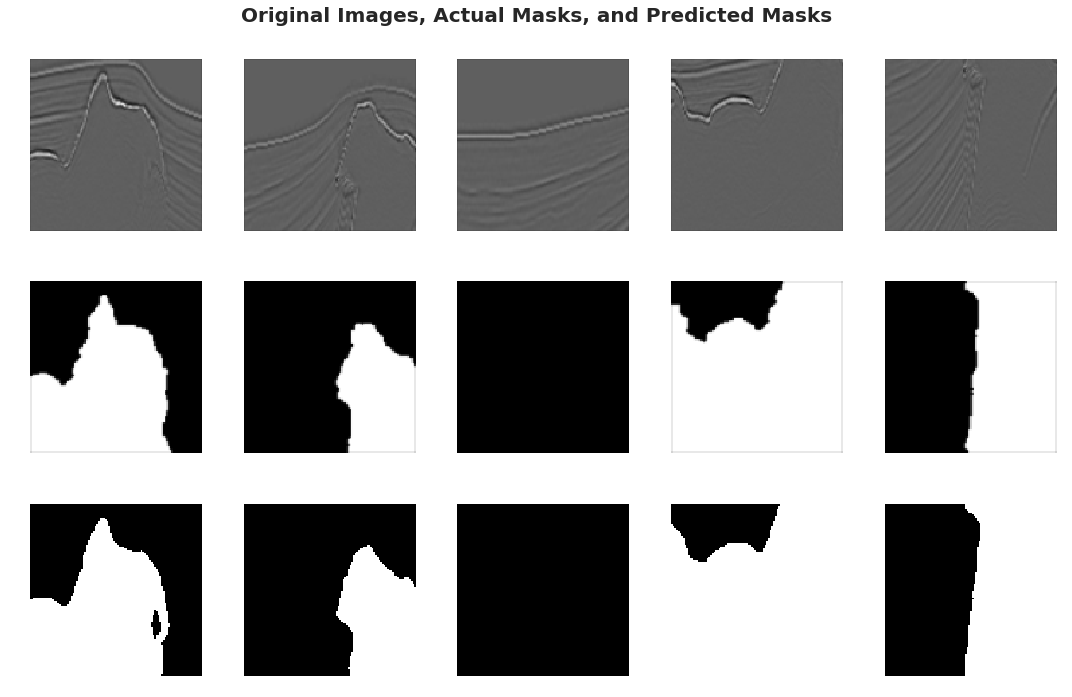

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to display
num_samples = 5

# Randomly select indices
indices = np.random.choice(range(x_test.shape[0]), num_samples, replace=False)
#indices = np.array([274, 307, 672, 434, 652])
# Set up the figure with subplots
fig, axes = plt.subplots(3, num_samples, figsize=(15, 10))
fig.suptitle('Original Images, Actual Masks, and Predicted Masks', fontsize=20, fontweight="bold")

for i, idx in enumerate(indices):
    # Original image in the first row
    axes[0, i].imshow(x_test[idx])

    axes[0, i].axis("off")
    
    # Actual mask in the second row
    axes[1, i].imshow(y_test_ori[idx].squeeze(), cmap='gray')

    axes[1, i].axis("off")
    
    # Predicted mask in the third row
    axes[2, i].imshow(preds[idx], cmap='gray')
    #axes[2, i].set_title("Predicted Mask", fontweight="bold")
    axes[2, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to display
num_samples = 5

# Randomly select indices
#indices = np.random.choice(range(x_valid_ori.shape[0]), num_samples, replace=False)

# Set up the figure with subplots
fig, axes = plt.subplots(3, num_samples, figsize=(15, 10))
fig.suptitle('Original Images, Actual Masks, and Predicted Masks', fontsize=20, fontweight="bold")

for i, idx in enumerate(indices):
    # Original image in the first row
    axes[0, i].imshow(x_valid_ori[idx])

    axes[0, i].axis("off")
    
    # Actual mask in the second row
    axes[1, i].imshow(y_valid_ori[idx].squeeze(), cmap='gray')

    axes[1, i].axis("off")
    
    # Predicted mask in the third row
    axes[2, i].imshow(preds[idx], cmap='gray')
    #axes[2, i].set_title("Predicted Mask", fontweight="bold")
    axes[2, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
x_valid_ori = np.array([downsample(x) for x in x_valid])

In [ ]:
def UXception(input_shape=(None, None, 3)):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    # 10 -> 20
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.1)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    # 10 -> 20
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(0.1)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    # 20 -> 40
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    # 40 -> 80
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    
    # 80 -> 160
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(0.1/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model


In [27]:
# model
from keras.applications.xception import Xception
from keras.utils.generic_utils import get_custom_objects
from keras.applications.xception import Xception
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
#model2 = UXception(input_shape=(img_size_target,img_size_target,3))


In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [ ]:
batch_size = 500
preds_test = []
i = 0
while i < test_df.shape[0]:
    index_val = test_df.index[i:i+batch_size]
#     depth_val = test_df.z[i:i+batch_size]
    x_test = np.array([upsample(np.array(load_img("/kaggle/working/images/{}.png".format(idx), grayscale=True))) / 255 for idx in (index_val)]).reshape(-1, img_size_target, img_size_target, 1)
    x_test = np.repeat(x_test,3,axis=3)
    preds_test_temp1 = predict_result(model,x_test,img_size_target,32)
    preds_test_temp2 = predict_result(model2,x_test,img_size_target,32)
    preds_test_temp3 = predict_result(model3,x_test,img_size_target,32)
    all_preds = np.stack([preds_test_temp1, preds_test_temp2, preds_test_temp3], axis=-1)
    weights = [0.3, 0.2, 0.3]  # Example weights
    ensemble_preds = np.average(all_preds, axis=-1, weights=weights)
    if i==0:
        preds_test = ensemble_preds
    else:
        preds_test = np.concatenate([preds_test,ensemble_preds],axis=0)
    if i%2000==0:
        print('Images Processed:',i)
    i += batch_size    
print('Done!')


In [38]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [53]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_valid[i]) > 0.5)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

A Jupyter Widget

In [54]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('all_net2.csv')

In [74]:
from IPython.display import FileLink
FileLink(r'./u-tgs_seam-all.h5')

/kaggle/working/u-tgs_seam-all.h5

In [70]:
print('test')

test
